# Important Library Imports

In [10]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
import math
from torchvision.utils import make_grid
import time
import pickle
import torch.nn.functional

# Helper Functions

In [11]:
def validate_model(model, val_loader, device):
    with torch.no_grad():
        num_correct = 0
        total = 0
        model.eval()
        for batch, labels in val_loader:
            batch = batch.to(device)
            labels = labels.to(device)

            pred = model(batch)
            num_correct += (pred.argmax(dim=1) == labels).type(torch.float).sum().item()
            total += len(labels)
        accuracy = (num_correct / total) * 100
        return accuracy

def test_model(model, test_loader, device):
    with torch.no_grad():
        num_correct = 0
        total = 0
        model.eval()
        for batch, labels in test_loader:
            batch = batch.to(device)
            labels = labels.to(device)

            pred = model(batch)
            num_correct += (pred.argmax(dim=1) == labels).type(torch.float).sum().item()
            total += len(labels)
        accuracy = (num_correct / total) * 100
        return accuracy

# Load and Augment Dataset

In [ ]:
# Create Data Augmentation
data_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomApply([
            transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), fill=255)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(p=1.0)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomVerticalFlip(p=1.0)
        ], p=0.2),
    ]),
    transforms.ToTensor()
])

# transforms.RandomApply([
#             transforms.ElasticTransform(alpha=40.0, sigma=8.0)
#         ], p=0.2),
#         transforms.RandomApply([
#             transforms.RandomAffine(degrees=0, shear=20, fill=255)
#         ], p=0.2),


# Load Training, Validation, and Testing Images
LABELS = ["Apple Scab", "Apple Black Rot", "Apple Cedar Rust", "Apple Healthy", "Blueberry Healthy", "Cherry Healthy", "Cherry Powdery Mildew", "Corn Cercospora Leaf Spot", "Corn Common Rust", "Corn Healthy", "Corn Northern Leaf Blight", "Grape Black Rot", "Grape Black Measles", "Grape Healthy", "Grape Isariopsis Leaf Spot", "Orange Haunglonbing",
          "Peach Bacterial Spot", "Peach Healthy", "Bell Pepper Bacterial Spot", "Bell Pepper Healthy", "Potato Early Blight", "Potato Healthy", "Potato Late Blight", "Raspberry Healthy", "Soybean Healthy", "Squash Powdery Mildew", "Strawberry Healthy", "Strawberry Leaf Scorch", "Tomato Bacterial Spot", "Tomato Early Blight", "Tomato Healthy",
          "Tomato Late Blight", "Tomato Leaf Mold", "Tomato Septoria Leaf Spot", "Tomato Spider Mites", "Tomato Target Spot", "Tomato Mosaic Virus", "Tomato Yellow Leaf Curl Virus"]

BATCH_SIZE = 64
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Running on {DEVICE}")
folder_path = "PlantVillage"

train_set = ImageFolder(root=folder_path + "\Training", transform=data_transforms)
val_set = ImageFolder(root=folder_path + "\Validation", transform=transforms.ToTensor())
test_set = ImageFolder(root=folder_path + "\Testing", transform=transforms.ToTensor())

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

Running on cuda


# Construct Student

In [36]:
class StudentModel(nn.Module):
    def __init__(self):
        super().__init__()

        conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1).to(DEVICE)
        relu1 = nn.LeakyReLU().to(DEVICE)
        pool1 = nn.MaxPool2d(kernel_size=2).to(DEVICE)

        conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1).to(DEVICE)
        relu2 = nn.LeakyReLU().to(DEVICE)
        pool2 = nn.MaxPool2d(kernel_size=2).to(DEVICE)

        conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1).to(DEVICE)
        relu3 = nn.LeakyReLU().to(DEVICE)
        Apool = nn.AdaptiveAvgPool2d(1).to(DEVICE)
        
        flatten = nn.Flatten().to(DEVICE)

        fcn1 = nn.Linear(128, 38).to(DEVICE)
        # softmax = nn.Softmax().to(DEVICE)

        self.layers = nn.Sequential(conv1, relu1, pool1, conv2, relu2, pool2, conv3, relu3, Apool, flatten, fcn1).to(DEVICE)

    def forward(self, x):
        return self.layers(x).to(DEVICE)

def distillation_loss(student_pred, teacher_pred, labels, T, alpha):
    # Calculate soft targets
    soft_loss = nn.functional.kl_div(nn.functional.log_softmax(student_pred / T, dim=1), nn.functional.softmax(teacher_pred / T, dim=1), reduction='batchmean') * (T * T)

    # Calculate soft targets
    criterion = nn.CrossEntropyLoss()
    hard_loss = criterion(student_pred, labels)

    # Calculate total loss
    loss = alpha * hard_loss + (1 - alpha) * soft_loss

    return loss

# Train Student

In [37]:
from DiseasedCNN import DiseasedCNN

NUM_EPOCHS = 50

# Load teacher
teacher = DiseasedCNN()
teacher.load_state_dict(torch.load('DiseasedCNN_statedict.pth'))
teacher.layers[-1] = nn.Identity()
teacher.eval().to(DEVICE)


# Init hyperparameters
learning_rate = 0.0005
adam_beta1 = 0.9
adam_beta2 = 0.999
T = 4
ALPHA = 0.7
# Create student
student = StudentModel()
student.train()
optimizer = torch.optim.Adam(params=student.parameters(), lr=learning_rate, betas=(adam_beta1, adam_beta2), weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epoch_loss = []
validation_acc = []

student.to(DEVICE)
for epoch in range(NUM_EPOCHS):
    train_loss = []
    print("Epoch: %d" % epoch)
    for step_num, (batch, labels) in enumerate(train_loader):
        batch = batch.to(DEVICE)
        labels = labels.to(DEVICE)

        student_pred = student(batch)

        with torch.no_grad():
            teacher_pred = teacher(batch)

        loss = distillation_loss(student_pred, teacher_pred, labels, T, ALPHA)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss.append(loss.item())

    # Perform validation and store accuracy
    validation_accuracy = validate_model(student, val_loader, DEVICE)
    validation_acc.append(validation_accuracy)
    print(validation_accuracy)

    # print(test_model(student, train_loader, DEVICE))

    if epoch != 0 and epoch % 10 == 0:
        scheduler.step()

    # Track average loss for each epoch
    print(sum(train_loss) / len(train_loss))
    epoch_loss.append(sum(train_loss) / len(train_loss))

Epoch: 0
28.835870012340603
16.415542296802297
Epoch: 1
38.17359111476758
13.89003774138058
Epoch: 2
44.68668586315645
11.977862829320571
Epoch: 3
51.44659262306321
10.717417649661794
Epoch: 4
54.600301659125186
9.733371829986572
Epoch: 5
57.04099821746881
9.079883945689481
Epoch: 6
60.09872480460716
8.420035871337442
Epoch: 7
62.621692033456746
7.879515357578502
Epoch: 8
66.00850130261895
7.4803088300368366
Epoch: 9
66.29644864938983
7.135344495492823
Epoch: 10
67.57164404223228
6.932611851131215
Epoch: 11
68.62745098039215
6.655470975707559
Epoch: 12
69.57356369121075
6.480896015728221
Epoch: 13
69.65583436171671
6.340228173312019
Epoch: 14
70.87618264088852
6.205110865480759
Epoch: 15
71.8634306869601
6.061181848890641
Epoch: 16
71.78116001645414
5.954630216430215
Epoch: 17
72.57644316467847
5.820147027688868
Epoch: 18
73.48142054024407
5.718623507724089
Epoch: 19
73.27574386397916
5.616482040461372
Epoch: 20
74.60578637049225
5.512629030732548
Epoch: 21
73.98875634169751
5.42482644

### Plot Loss

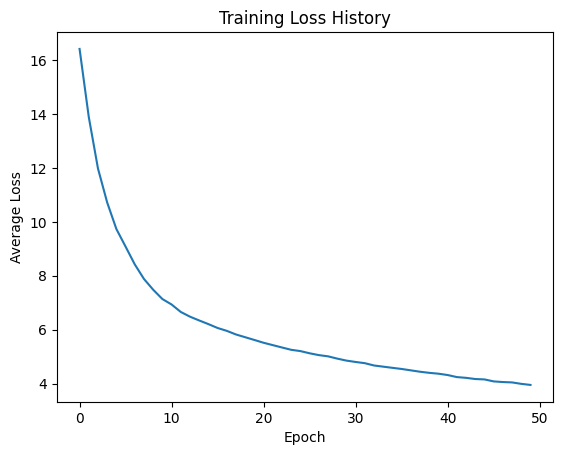

In [38]:
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.plot(epoch_loss)
plt.savefig("finalmodelinfo/StudentModel_TrainingLoss")
plt.show()

### Plot Validation Accuracy

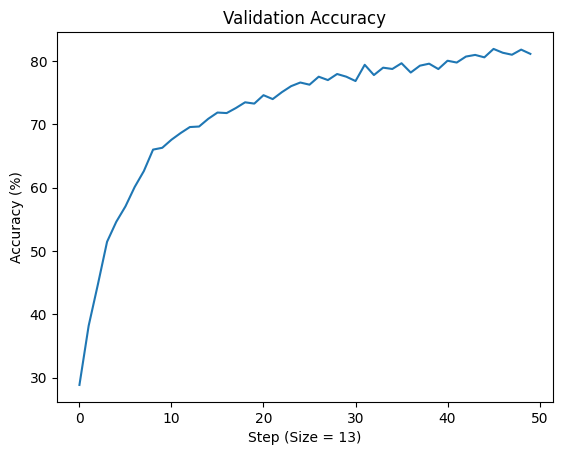

In [39]:
plt.title("Validation Accuracy")
plt.xlabel("Step (Size = 13)")
plt.ylabel("Accuracy (%)")
plt.plot(validation_acc)
plt.savefig("finalmodelinfo/StudentModel_ValAcc")
plt.show()

# Test Model

In [40]:
accuracy = test_model(model=student, test_loader=test_loader, device=DEVICE)
print("Model accuracy: %f" % accuracy)

Model accuracy: 80.521300


### Save Model

##### Save Full Model

In [41]:
torch.save(student, 'finalmodelinfo/StudentModel.pth')

##### Save Model State Dict

In [42]:
torch.save(student.state_dict(), "finalmodelinfo/StudentModel_statedict.pth")

##### Save Optimizer State

In [43]:
torch.save({
    'epoch': epoch,
    'model_state_dict': student.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "studentmodel_XX_optimizer_state.pth")

##### Save Training Info

In [44]:
file_path = "finalmodelinfo/StudentModel_training_info.pickle"
info = {}
info["epoch_loss"] = epoch_loss
info["validation_acc"] = validation_acc
with open(file_path, "wb") as file:
    pickle.dump(info, file)